# **Simple Linear Regression using Pytorch.**

In [179]:
import torch
import torch.nn as nn
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

# **Download the data from Kaggle.**

For this simple regression project we will be using the Melbourn housing [dataset](https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv) from Kaggle.

<span style="color:red">**Note:** _Please make sure you have API token generated and store under `users/.kaggle/kaggle.json` more information can be found [here](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication)_</span>

In [180]:
# Set the path to the file you'd like to load
file_path = "Melbourne_housing_FULL.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "anthonypino/melbourne-housing-market",
  file_path,
)

print("First 5 records:", df.head())

First 5 records:        Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/09/2016       2.5    3067.0  ...       1.0  1.0     126.0           NaN   
1  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
2  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
3  4/02/2016       2.5    3067.0  ...       2.0  1.0       0.0           NaN   
4  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   

   YearBuilt         CouncilArea Lattitude  Longtit

In [181]:
# Show the shape of the dataframe
print(f"Shape of the dataframe\nNumber of columns :{df.shape[1]}\nNumber of Rows: {df.shape[0]}")

Shape of the dataframe
Number of columns :21
Number of Rows: 34857


In [182]:
# Check for NaN values
df.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [183]:
# Describe the Numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,34857.0,3.031012e+00,0.969933,1.00000,2.00000,3.0000,4.000000e+00,1.600000e+01
Price,27247.0,1.050173e+06,641467.130105,85000.00000,635000.00000,870000.0000,1.295000e+06,1.120000e+07
Distance,34856.0,1.118493e+01,6.788892,0.00000,6.40000,10.3000,1.400000e+01,4.810000e+01
Postcode,34856.0,3.116063e+03,109.023903,3000.00000,3051.00000,3103.0000,3.156000e+03,3.978000e+03
Bedroom2,26640.0,3.084647e+00,0.980690,0.00000,2.00000,3.0000,4.000000e+00,3.000000e+01
Bathroom,26631.0,1.624798e+00,0.724212,0.00000,1.00000,2.0000,2.000000e+00,1.200000e+01
Car,26129.0,1.728845e+00,1.010771,0.00000,1.00000,2.0000,2.000000e+00,2.600000e+01
Landsize,23047.0,5.935990e+02,3398.841946,0.00000,224.00000,521.0000,6.700000e+02,4.330140e+05
BuildingArea,13742.0,1.602564e+02,401.267060,0.00000,102.00000,136.0000,1.880000e+02,4.451500e+04
YearBuilt,15551.0,1.965290e+03,37.328178,1196.00000,1940.00000,1970.0000,2.000000e+03,2.106000e+03


In [184]:
# Describe non-numeric columns
df.describe(exclude=np.number)

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
count,34857,34857,34857,34857,34857,34857,34854,34854
unique,351,34009,3,9,388,78,33,8
top,Reservoir,5 Charles St,h,S,Jellis,28/10/2017,Boroondara City Council,Southern Metropolitan
freq,844,6,23980,19744,3359,1119,3675,11836


In [185]:
# Get the cardinility of the dataframe
pd.DataFrame({"Count" : df.shape[0], "Null": df.isnull().sum(), "Null %": df.isnull().mean()*100, "Cardinility": df.nunique()})

,Count,Null,Null %,Cardinility
Suburb,34857,0,0.000000,351
Address,34857,0,0.000000,34009
Rooms,34857,0,0.000000,12
Type,34857,0,0.000000,3
Price,34857,7610,21.832057,2871
Method,34857,0,0.000000,9
SellerG,34857,0,0.000000,388
Date,34857,0,0.000000,78
Distance,34857,1,0.002869,215
Postcode,34857,1,0.002869,211


In [186]:
# Delete unnecessary columns
df.drop(columns=["Address", "Postcode","SellerG","Lattitude","Longtitude"], inplace=True)

In [187]:
# Delete the smallest number of missing values (Nulls) ​​in columns to reduce missing values a from the data
df.dropna(subset=['Price','Bedroom2','Distance','Bedroom2','Bathroom',
                   'Car','CouncilArea','Regionname','Propertycount'] , inplace=True)

In [188]:
df.replace(0.0 , df['Landsize'].median() , inplace = True)

In [189]:
# Fill missing values (null) as possible

df.fillna({'Landsize' : df['Landsize'].ffill(limit=2),
           'BuildingArea': df['BuildingArea'].ffill(limit=2),
           'YearBuilt' : df['YearBuilt'].ffill(limit=2)} , inplace = True)

df.fillna({'Landsize' : df['Landsize'].bfill(limit=2),
           'BuildingArea': df['BuildingArea'].bfill(limit=2),
           'YearBuilt' : df['YearBuilt'].bfill(limit=2)} , inplace = True)

In [190]:
# Check Number of missing value
df.isna().sum()

Suburb             0
Rooms              0
Type               0
Price              0
Method             0
Date               0
Distance           0
Bedroom2           0
Bathroom           0
Car                0
Landsize         138
BuildingArea     678
YearBuilt        379
CouncilArea        0
Regionname         0
Propertycount      0
dtype: int64

In [191]:
# Delete the rest of the missing values
df.dropna(inplace=True)

In [192]:
# The New of Shape Data
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Row : 19554
Number of Columns : 16


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19554 entries, 1 to 34856
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         19554 non-null  object 
 1   Rooms          19554 non-null  int64  
 2   Type           19554 non-null  object 
 3   Price          19554 non-null  float64
 4   Method         19554 non-null  object 
 5   Date           19554 non-null  object 
 6   Distance       19554 non-null  float64
 7   Bedroom2       19554 non-null  float64
 8   Bathroom       19554 non-null  float64
 9   Car            19554 non-null  float64
 10  Landsize       19554 non-null  float64
 11  BuildingArea   19554 non-null  float64
 12  YearBuilt      19554 non-null  float64
 13  CouncilArea    19554 non-null  object 
 14  Regionname     19554 non-null  object 
 15  Propertycount  19554 non-null  float64
dtypes: float64(9), int64(1), object(6)
memory usage: 2.5+ MB


In [194]:
# Check Number of missing value
df.isna().sum()

Suburb           0
Rooms            0
Type             0
Price            0
Method           0
Date             0
Distance         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Regionname       0
Propertycount    0
dtype: int64

In [195]:
# Describe Numeric (After Delete Null)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,19554.0,3.063977e+00,0.947531,1.0,2.0,3.0,4.0,16.0
Price,19554.0,1.086337e+06,656809.706148,85000.0,655000.0,905000.0,1330000.0,11200000.0
Distance,19554.0,1.161021e+01,11.204293,0.7,6.6,10.5,14.2,516.0
Bedroom2,19554.0,3.444564e+00,14.233947,1.0,2.0,3.0,4.0,516.0
Bathroom,19554.0,2.442774e+00,20.804598,1.0,1.0,1.0,2.0,516.0
Car,19554.0,3.332699e+01,123.314697,1.0,1.0,2.0,2.0,516.0
Landsize,19554.0,6.739364e+02,3957.713316,1.0,347.0,533.0,668.0,433014.0
BuildingArea,19554.0,1.618288e+02,466.668698,1.0,102.0,135.0,186.0,44515.0
YearBuilt,19554.0,1.967171e+03,36.761057,1196.0,1950.0,1970.0,2000.0,2019.0
Propertycount,19554.0,7.480767e+03,4387.629276,83.0,4380.0,6543.0,10331.0,21650.0


In [196]:
# Describe Non-Numeric (After Delete Null)
df.describe(exclude=np.number)

,Suburb,Type,Method,Date,CouncilArea,Regionname
count,19554,19554,19554,19554,19554,19554
unique,337,3,5,78,33,8
top,Reservoir,h,S,28/10/2017,Boroondara City Council,Southern Metropolitan
freq,449,14685,12784,594,1808,5956


In [197]:
# The New Cardinality
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Cardinality':df.nunique()
})

,Count,Null,Null %,Cardinality
Suburb,19554,0,0.0,337
Rooms,19554,0,0.0,11
Type,19554,0,0.0,3
Price,19554,0,0.0,2561
Method,19554,0,0.0,5
Date,19554,0,0.0,78
Distance,19554,0,0.0,210
Bedroom2,19554,0,0.0,14
Bathroom,19554,0,0.0,10
Car,19554,0,0.0,13


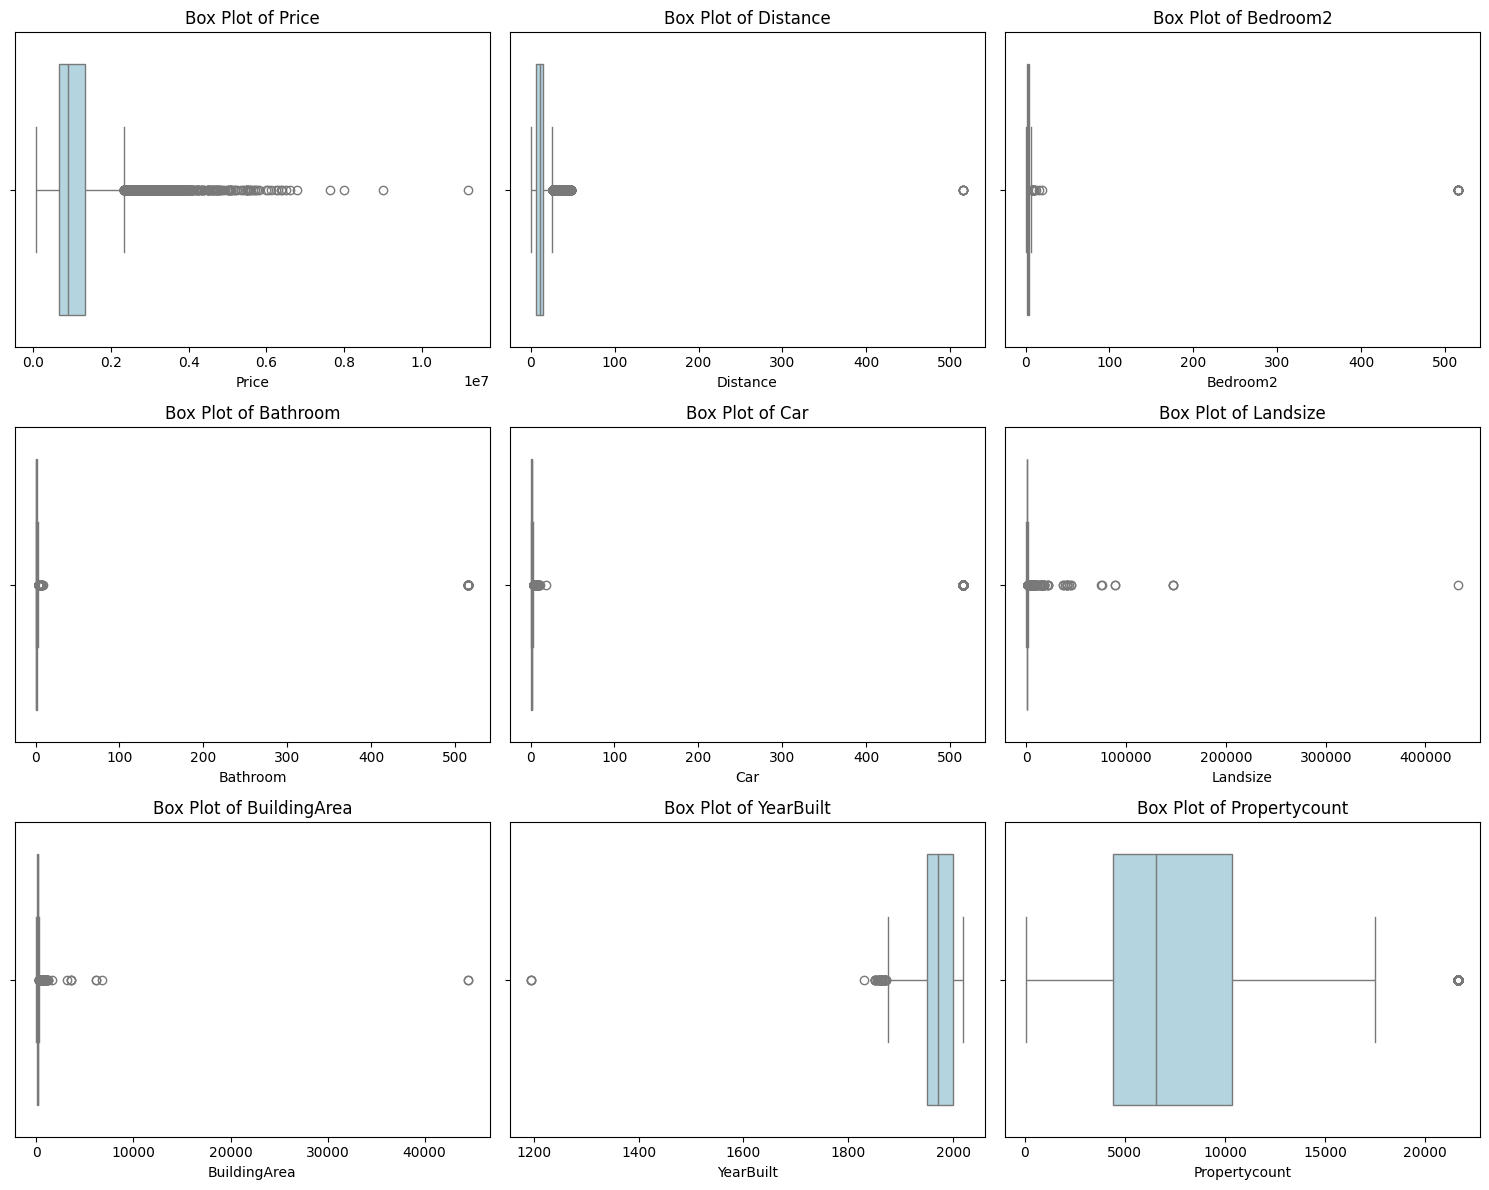

In [198]:
# Check for outliers
numerical_columns = ["Price", "Distance", "Bedroom2", "Bathroom", "Car", "Landsize",
                     "BuildingArea", "YearBuilt", "Propertycount"]

plt.figure(figsize=(15, 12))
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, idx)
    sns.boxplot(x = df[col], color = "lightblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [199]:
# Remove outliers
threshold = 1.5

df_clean = df.copy()
for col in numerical_columns:
    Q1 = df_clean[col].quantile(0.25) 
    Q3 = df_clean[col].quantile(0.75)  
    IQR = Q3 - Q1 
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]

# The New of Shape Cleaned Data
print(f"Number of Row : {df_clean.shape[0]}\nNumber of Columns : {df_clean.shape[1]}")



Number of Row : 14073
Number of Columns : 16


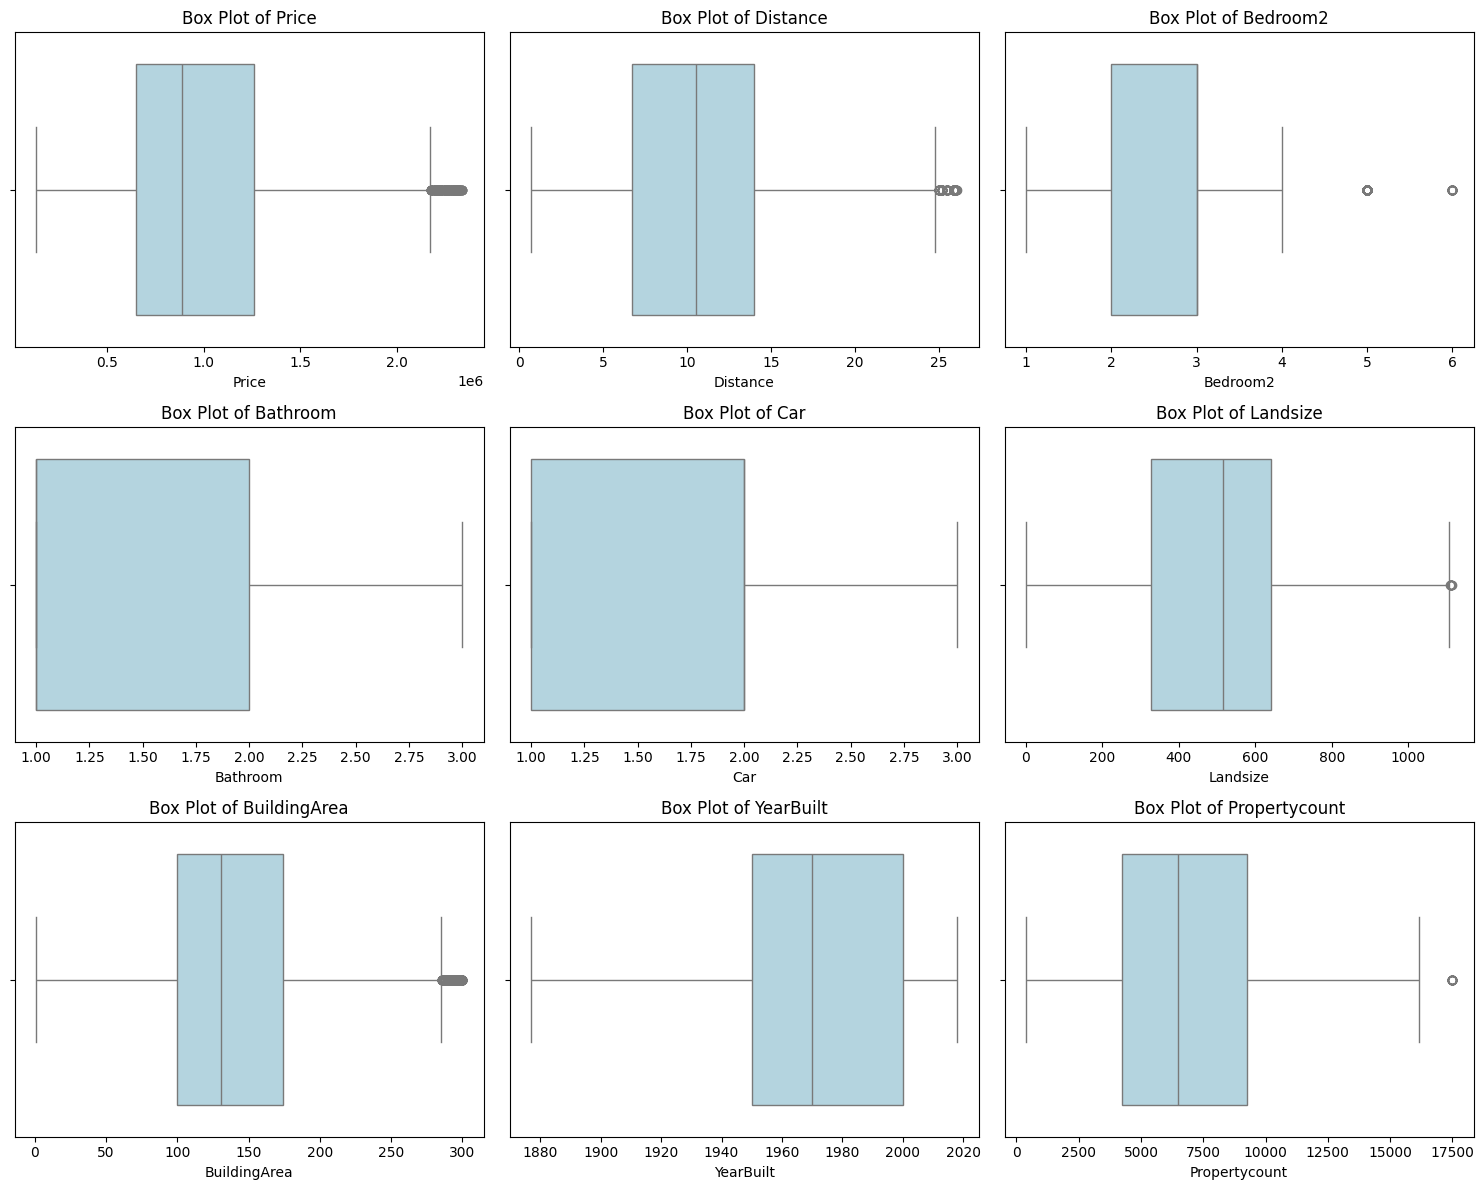

In [200]:
# Check for outliers
numerical_columns = ["Price", "Distance", "Bedroom2", "Bathroom", "Car", "Landsize",
                     "BuildingArea", "YearBuilt", "Propertycount"]

plt.figure(figsize=(15, 12))
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, idx)
    sns.boxplot(x = df_clean[col], color = "lightblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [201]:
df_clean.reset_index(drop=True)
df_clean.head()

,Suburb,Rooms,Type,Price,Method,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount
1,Abbotsford,2,h,1480000.0,S,3/12/2016,2.5,2.0,1.0,1.0,202.0,79.0,1900.0,Yarra City Council,Northern Metropolitan,4019.0
5,Abbotsford,3,h,850000.0,PI,4/03/2017,2.5,3.0,2.0,1.0,94.0,150.0,1900.0,Yarra City Council,Northern Metropolitan,4019.0
6,Abbotsford,4,h,1600000.0,VB,4/06/2016,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,Northern Metropolitan,4019.0
14,Abbotsford,2,h,1636000.0,S,8/10/2016,2.5,2.0,1.0,2.0,256.0,107.0,1890.0,Yarra City Council,Northern Metropolitan,4019.0
17,Abbotsford,1,u,300000.0,S,8/10/2016,2.5,1.0,1.0,1.0,516.0,107.0,1890.0,Yarra City Council,Northern Metropolitan,4019.0


In [234]:
columns_to_encode = df_clean.select_dtypes(object)
label_encoder = LabelEncoder()
for col in columns_to_encode:
    df_clean[col] = label_encoder.fit_transform(df_clean[col])
df_clean.head()


,Suburb,Rooms,Type,Price,Method,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount
1,0,2,0,1480000.0,1,60,2.5,2.0,1.0,1.0,202.0,79.0,1900.0,25,2,4019.0
5,0,3,0,850000.0,0,64,2.5,3.0,2.0,1.0,94.0,150.0,1900.0,25,2,4019.0
6,0,4,0,1600000.0,4,65,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,25,2,4019.0
14,0,2,0,1636000.0,1,75,2.5,2.0,1.0,2.0,256.0,107.0,1890.0,25,2,4019.0
17,0,1,2,300000.0,1,75,2.5,1.0,1.0,1.0,516.0,107.0,1890.0,25,2,4019.0


## **Normalizing and splitting the data** 

In [269]:
X = df_clean.drop(columns=["Price", "Date"], axis=1).values
y = df_clean["Price"].values

In [270]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.25 , random_state = 44 , shuffle = True)
print(f"Shape of X_Train {X_train.shape}")
print(f"Shape of X_Test {X_test.shape}")
print(f"Shape of Y_Train {y_train.shape}")
print(f"Shape of Y_Test {y_test.shape}")

Shape of X_Train (10554, 14)
Shape of X_Test (3519, 14)
Shape of Y_Train (10554,)
Shape of Y_Test (3519,)


In [271]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).requires_grad_()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# **Build Linear Regression Model**

In [273]:
# Create a Linear Regression Model class
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  

    def forward(self, x):
        out = self.linear(x)
        return out
    
model = LinearRegressionModel(input_dim=X_train_tensor.shape[1], output_dim=1)
# Instantiate the loss function
criterion = nn.MSELoss()

# Instantiate the optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# **Model Training**
epochs = 100

for epoch in range(1, epochs+1):

    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss))

epoch 1, loss 1173135556608.0
epoch 2, loss 1172940783616.0
epoch 3, loss 1172746010624.0
epoch 4, loss 1172551237632.0
epoch 5, loss 1172356464640.0
epoch 6, loss 1172161691648.0
epoch 7, loss 1171967049728.0
epoch 8, loss 1171772407808.0
epoch 9, loss 1171577765888.0
epoch 10, loss 1171382992896.0
epoch 11, loss 1171188482048.0
epoch 12, loss 1170993840128.0
epoch 13, loss 1170799460352.0
epoch 14, loss 1170604687360.0
epoch 15, loss 1170410307584.0
epoch 16, loss 1170215927808.0
epoch 17, loss 1170021416960.0
epoch 18, loss 1169827037184.0
epoch 19, loss 1169632526336.0
epoch 20, loss 1169438408704.0
epoch 21, loss 1169243897856.0
epoch 22, loss 1169049649152.0
epoch 23, loss 1168855400448.0
epoch 24, loss 1168661151744.0
epoch 25, loss 1168466903040.0
epoch 26, loss 1168272916480.0
epoch 27, loss 1168078536704.0
epoch 28, loss 1167884550144.0
epoch 29, loss 1167690432512.0
epoch 30, loss 1167496314880.0
epoch 31, loss 1167302328320.0
epoch 32, loss 1167108341760.0
epoch 33, loss 11

In [274]:
predictions = model(X_test_tensor)
predictions

tensor([[ 8912.9619],
        [ 6934.2720],
        [11037.7549],
        ...,
        [ 7543.5830],
        [10917.7705],
        [ 7043.3560]], grad_fn=<AddmmBackward0>)

/var/folders/wn/6q8gxksd5q76p1dxqnkgz3fr0000gn/T/ipykernel_96342/1809482819.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(X_test_tensor.detach().numpy(), y_test_tensor.detach().numpy(), "go", label='True Values', color='blue')


Text(0.5, 1.0, 'True vs Predicted Values')

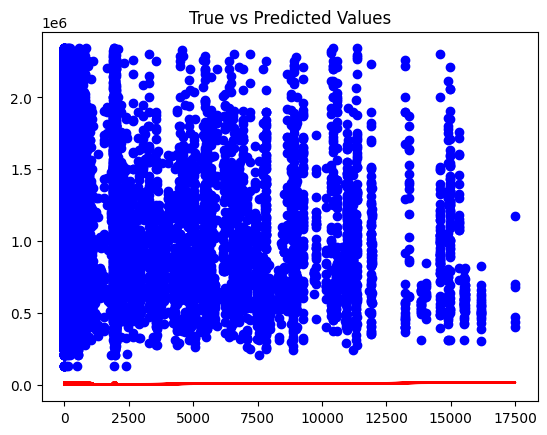

In [299]:
# Clear figure
plt.clf()
plt.plot(X_test_tensor.detach().numpy(), y_test_tensor.detach().numpy(), "go", label='True Values', color='blue')
plt.plot(X_test_tensor.detach().numpy(), predictions.detach().numpy(), label='Predictions', color='red')
plt.title('True vs Predicted Values')